# Toronto Bikeshare

The Toronto [Q3 and Q4 bikeshare ride data](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#343faeaa-c920-57d6-6a75-969181b6cbde) captures (anonymized) trips taken with the Toronto bikeshare system between July 1st and December 31st, 2016.  The data includes the trip start and end times, duration, and origin and destination stations.

The `bike_stations_15_11_2018.csv` file included with this repo was created from cleaned data from [the
station information JSON feed](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#84045f23-7465-0892-8889-7b6f91049b29)
accessible from the Toronto open data catalogue.  I couldn't find any data about station capacity or location from 2016, so will modify the 2018 data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

# Data Munging

### Download Station Data From publicbikesystem.net

In [2]:
# Download raw file (saved file downloaded on 15-11-2018)
# import requests
# stations = pd.DataFrame(requests.get(
#     'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information').json()['data']['stations'])
# stations.drop(columns=['cross_street', 'post_code', 'rental_methods'], inplace=True)
# stations.to_csv('./bike_stations_15_11_2018.csv')

### Read Data

In [3]:
stations = pd.read_csv('./bike_stations_15_11_2018.csv', index_col=0)

bike_fpth = os.environ.get('BIKESHARE_FOLDER_PATH')

bikes_q3 = pd.read_excel(bike_fpth + '2016_Bike_Share_Toronto_Ridership_Q3.xlsx')
bikes_q4 = pd.read_excel(bike_fpth + '2016_Bike_Share_Toronto_Ridership_Q4.xlsx',
                         converters={'trip_start_time': str, 'trip_stop_time': str})

Before we combine the data frames, we need to correct a serious timestamp formatting issue with `bikes_q4`.  There are three possible timestamp styles, likely because whomever was preparing the data accidentally swapped the month and date fields, and only corrected those timestamps that couldn't be stored:

```
2016-01-10 - used whenever the middle number is <= 12
2016-10-13 - sometimes used when the middle number is > 12
31/12/2016 - default used when the middle number is > 12
```

In [4]:
def reverse_timestamp(x):
    try:
        return datetime.datetime.strptime(x, '%Y-%d-%m %H:%M:%S')
    except:
        try:
            return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        except:
            return pd.to_datetime(x)

print(reverse_timestamp('2016-01-10 00:00:00'), '\n', reverse_timestamp('2016-10-13 23:59:00'), '\n',
      reverse_timestamp('31/12/2016 23:59'))

2016-10-01 00:00:00 
 2016-10-13 23:59:00 
 2016-12-31 23:59:00


In [5]:
bikes_q4['trip_start_time'] = bikes_q4['trip_start_time'].apply(reverse_timestamp)
bikes_q4['trip_stop_time'] = bikes_q4['trip_stop_time'].apply(reverse_timestamp)

In [6]:
bikes = pd.concat([bikes_q3, bikes_q4], axis=0)

### Clean Data

Do some preliminary cleaning of the bikes data.

In [7]:
bikes.columns

Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_name', 'to_station_name', 'user_type'],
      dtype='object')

In [8]:
# Drop any row with unknown stations.
bikes.dropna(subset=['from_station_name', 'to_station_name'], inplace=True)

# Drop any reference to "Base Station", which I assume is a servicing centre.
base_station_trips = bikes.loc[(bikes['from_station_name'] == 'Base Station') |
                               (bikes['to_station_name'] == 'Base Station')].index
bikes.drop(index=base_station_trips, inplace=True)
bikes.reset_index(drop=True, inplace=True)

In [9]:
# Create a dataframe of all unique bike stations from bikes.
all_bike_stations = pd.DataFrame(
    list(set(np.concatenate([bikes['from_station_name'].unique(), bikes['to_station_name'].unique()]))),
    columns=['Name'])

The station dataset is from 2018, but the ride data is from 2016, and since then there have been multiple station relocations and expansions (eg. in [August 2018](https://bikesharetoronto.com/news/bike-share-toronto-expands-to-new-neighbourhoods/)).  In cases where stations' names have changed, we'll need to associate the old names with the new, and in cases where they've closed down, we'll do a best guess of their geolocation based on their name or address.

In [10]:
# Find all names in `all_bike_stations` not in `stations`.
set(all_bike_stations['Name']) - (set(stations['name'].unique()))

{'424 Wellington St. W',
 'Bathurst St / Queens Quay W',
 'Bay St / Bloor St W',
 'Beverly St / College St W',
 'Bloor GO / UP Station/ Rail Path',
 'Bremner Blvd / Spadina Ave',
 'College St W / Borden St',
 'College St W / Crawford St',
 'College St W / Huron St',
 'College St W / Major St',
 'College St W / Markham St',
 'Davenport Rd / Bedford Rd',
 'Dundas St / Yonge St',
 'Front St / Bay St (North Side)',
 'Front St / Yonge St (Hockey Hall of Fame)',
 "HTO Park (Queen's Quay W)",
 'Landsdowne Subway Green P',
 'Margueretta St / College St W',
 'Ossington Ave / College St W',
 'Princess St / Adelaide St',
 'Queen St E / Berkely St',
 'Queens Park / Bloor St W',
 'Rusholme Park Cres / College St W',
 'Sherbourne St / Wellesley St',
 'St George St / Bloor St W',
 'Temperance St / Yonge St',
 'Wellesley St E / Yonge St Green P',
 'Widmer St / Adelaide St '}

In [11]:
# Remove periods to help with matching
all_bike_stations['CleanName'] = all_bike_stations['Name'].str.replace('[.]', '')
stations['cleanname'] = stations['name'].str.replace('[.]', '')

In [12]:
# Create a column of station names updated as needed with their 2018 equivalent.
all_bike_stations['ModernCleanName'] = all_bike_stations['CleanName'].copy()
all_bike_stations['ModernCleanName'] = (all_bike_stations['ModernCleanName']
                                        .str.replace('College St W', 'College St'))

new_station_names = {
    'Bathurst St / Queens Quay W': 'Bathurst St/Queens Quay(Billy Bishop Airport)',
    'Beverly St / College St W': 'Beverly St / College St',
    'Bloor GO / UP Station/ Rail Path': 'Bloor GO / UP Station (West Toronto Railpath)',
    'Bremner Blvd / Spadina Ave': 'Spadina Ave / Bremner Blvd',
    'Dundas St / Yonge St': 'Dundas St W / Yonge St',
    'Landsdowne Subway Green P': 'Lansdowne Subway Green P',
    'Front St / Bay St (North Side)': 'Front St W / Bay St (North Side)',
    'Front St / Yonge St (Hockey Hall of Fame)': 'Front St W / Yonge St (Hockey Hall of Fame)',
    "HTO Park (Queen's Quay W)": 'HTO Park (Queens Quay W)',
    'Princess St / Adelaide St': 'Princess St / Adelaide St E',
    'Queen St E / Berkely St': 'Queen St E / Berkeley St',
    'Queens Park / Bloor St W': "Queen's Park / Bloor St W",
    'Sherbourne St / Wellesley St': 'Sherbourne St / Wellesley St E',
    'Wellesley St E / Yonge St Green P': 'Wellesley St E / Yonge St (Green P)',
    'Widmer St / Adelaide St ': 'Widmer St / Adelaide St W'}

for key, item in new_station_names.items():
    all_bike_stations.loc[all_bike_stations['ModernCleanName'] == key, 'ModernCleanName'] = item

In [13]:
# For stations that no longer exist, determined their geolocations using their
# name and Google Maps.  Append this information to `stations`.
station_addendum = pd.DataFrame({
    'address': ['Bay St / Bloor St W', 'Davenport Rd / Bedford Rd', 'Temperance St / Yonge St'],
    'capacity': [stations['capacity'].median(), stations['capacity'].median(), stations['capacity'].median()],
    'lat': [43.669678, 43.674310, 43.651035],
    'lon': [-79.389437, -79.399766, -79.378680],
    'name': ['Bay St / Bloor St W', 'Davenport Rd / Bedford Rd', 'Temperance St / Yonge St'],
    'station_id': stations['station_id'].unique().max() + np.arange(1, 4),
    'cleanname': ['Bay St / Bloor St W', 'Davenport Rd / Bedford Rd', 'Temperance St / Yonge St']
})

stations = pd.concat([stations, station_addendum], sort=True)
stations.reset_index(drop=True, inplace=True)

In [14]:
all_bike_stations = all_bike_stations.merge(stations, how='left', left_on='ModernCleanName',
                                            right_on='cleanname')

In [15]:
# Check that we have no NaNs
all_bike_stations.loc[np.any(all_bike_stations.isnull(), axis=1), :]

,Name,CleanName,ModernCleanName,address,capacity,cleanname,lat,lon,name,station_id


In [16]:
all_bike_stations.drop(labels=['CleanName', 'ModernCleanName', 'cleanname', 'name'],
                       axis=1, inplace=True)
all_bike_stations['capacity'] = all_bike_stations['capacity'].astype(int)

### Add Station ID to `bikes`

We add the station ID to the `bikes` dataframe using `all_bike_stations`.

In [17]:
# Associate departing and arriving station IDs with rides.
bike_station_hasher = dict(zip(all_bike_stations['Name'], all_bike_stations['station_id']))
bikes['from_station_id'] = (
    bikes['from_station_name'].apply(lambda x: bike_station_hasher[x]))
bikes['to_station_id'] = (
    bikes['to_station_name'].apply(lambda x: bike_station_hasher[x]))

### Correct Timestamps

First we need to convert trip start and end times to datetime.

In [18]:
bikes['trip_start_time'] = pd.to_datetime(bikes['trip_start_time'])
bikes['trip_stop_time'] = pd.to_datetime(bikes['trip_stop_time'])

Timestamps that aren't in 2016 are invalid, so let's get rid of them.

In [19]:
bikes.drop(bikes.index[(bikes['trip_start_time'] < '2016-01-01 00:00:00') |
                       (bikes['trip_start_time'] > '2017-01-01 00:00:00')], inplace=True)

Let's do a quick check of the distribution of rides over the course of the year.

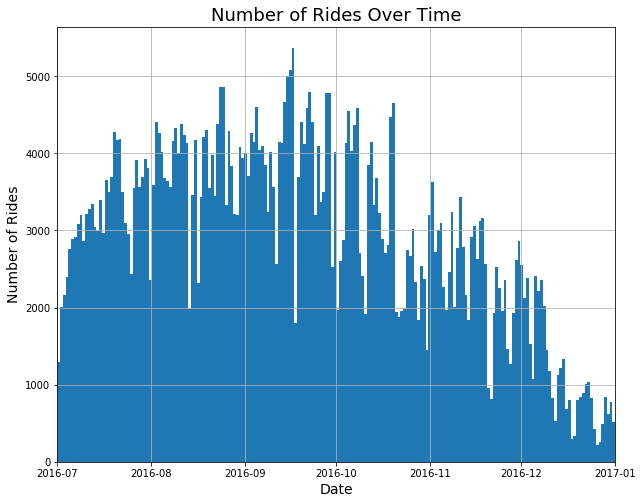

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
bikes['trip_start_time'].hist(ax=ax, bins=200)
ax.set_xlim(['2016-07-01 00:00:00', '2017-01-01 00:00:00'])
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Number of Rides", fontsize=14)
ax.set_title("Number of Rides Over Time", fontsize=18);

Let's also check the distribution of rides over the course of the day:

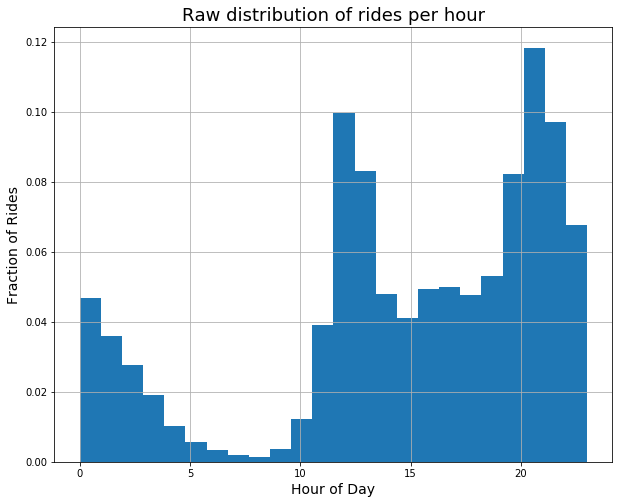

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
bhour = bikes['trip_start_time'].apply(lambda x: x.hour)
bwkdy = bikes['trip_start_time'].apply(lambda x: x.weekday())
bhour[bwkdy < 5].hist(ax=ax, bins=24, density=True)
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("Fraction of Rides", fontsize=14)
ax.set_title("Raw distribution of rides per hour", fontsize=18);

It's very strange the two peaks are at noon and 8 PM.  [Anthony Ionno's analysis](https://ionnoant.github.io/2018-05-06_bike-sharing-post/) finds the same, but also finds the 2014 - 2015 data shows peaks at 8 AM and 5 PM, which feels much more reasonable to me.  This suggests that this datadump is in UTC rather than EST.  Let's correct the times (including correcting for daylight savings time for trips that **started** before November 6).

In [22]:
bikes.loc[(bikes['trip_start_time'] < '2016-11-06 02:00:00'), 'trip_start_time'] = (
    bikes.loc[(bikes['trip_start_time'] < '2016-11-06 02:00:00'), 'trip_start_time'] - datetime.timedelta(hours=4))
bikes.loc[(bikes['trip_start_time'] >= '2016-11-06 02:00:00'), 'trip_start_time'] = (
    bikes.loc[(bikes['trip_start_time'] >= '2016-11-06 02:00:00'), 'trip_start_time'] - datetime.timedelta(hours=5))
bikes.loc[(bikes['trip_start_time'] < '2016-11-06 02:00:00'), 'trip_stop_time'] = (
    bikes.loc[(bikes['trip_start_time'] < '2016-11-06 02:00:00'), 'trip_stop_time'] - datetime.timedelta(hours=4))
bikes.loc[(bikes['trip_start_time'] >= '2016-11-06 02:00:00'), 'trip_stop_time'] = (
    bikes.loc[(bikes['trip_start_time'] >= '2016-11-06 02:00:00'), 'trip_stop_time'] - datetime.timedelta(hours=5))

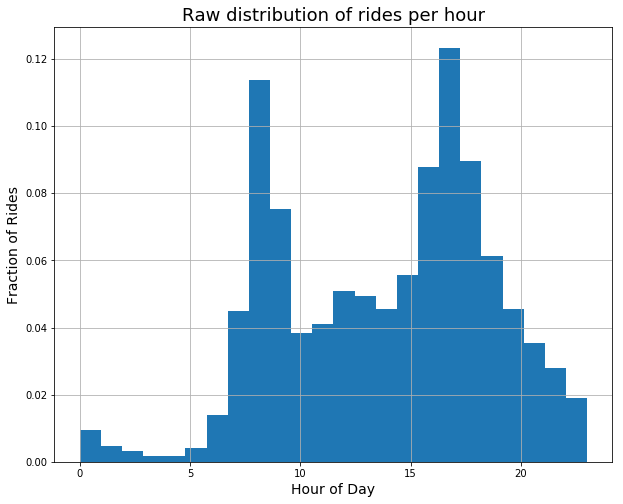

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
bhour = bikes['trip_start_time'].apply(lambda x: x.hour)
bwkdy = bikes['trip_start_time'].apply(lambda x: x.weekday())
bhour[bwkdy < 5].hist(ax=ax, bins=24, density=True)
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("Fraction of Rides", fontsize=14)
ax.set_title("Raw distribution of rides per hour", fontsize=18);

That's much better!

[Other](https://ionnoant.github.io/2018-05-06_bike-sharing-post/) [analyses](https://public.tableau.com/profile/tamara.augsten#!/vizhome/TorontoBikeShare_2/Dashboard1) indicate that typical ride times are quite small.  Let's check that.

In [24]:
bikes['trip_duration_seconds'].median() / 60.

11.283333333333333

This suggests that for aggregate analysis (eg. histogram plotting) we could look at the midpoint of the ride rather than the end.  Let's calculate that.

In [25]:
# Create a midpoint time.
bikes['trip_midpoint_time'] = (bikes['trip_start_time'] +
                               (bikes['trip_stop_time'] - bikes['trip_start_time']) / 2.)

In [26]:
# There's one trip from 2000, for some reason.  Remove it.
bikes.loc[:, 'trip_stop_time'].apply(lambda x: x.year).value_counts()

2016    585507
Name: trip_stop_time, dtype: int64

In [27]:
bad_years = bikes.loc[:, 'trip_start_time'].apply(lambda x: x.year) == 2000
bikes.drop(bikes.index[bad_years].values, inplace=True)

In [28]:
# Split timestamp into day and and fractional hour of day.
bikes['trip_month'] = (bikes.loc[:, 'trip_midpoint_time']
                             .apply(lambda x: x.month))
bikes['trip_day'] = (bikes.loc[:, 'trip_midpoint_time']
                             .apply(lambda x: x.day))
bikes_hour = bikes.loc[:, 'trip_midpoint_time'].apply(lambda x: x.hour)
bikes_min = bikes.loc[:, 'trip_midpoint_time'].apply(lambda x: x.minute)
bikes_sec = bikes.loc[:, 'trip_midpoint_time'].apply(lambda x: x.second)
bikes['trip_hour'] = bikes_hour + bikes_min / 60. + bikes_sec / 3600.

In [29]:
bikes['trip_weekday'] = (bikes.loc[:, 'trip_midpoint_time']
                              .apply(lambda x: x.weekday()))

# Data Exploration

Let's do some quick data exploration to figure out what we're dealing with.

In [30]:
# Couldn't find category10 definitions, so manually throwing these in here.
cat10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def get_cat10(i):
    return cat10[i % 10]

First, a quick check of how many rides, in total, per weekday:

In [31]:
bikes.loc[:, 'trip_weekday'].value_counts(sort=False)

0    85003
1    94248
2    94630
3    85677
4    90828
5    69227
6    65894
Name: trip_weekday, dtype: int64

As expected, there are more riders during the week than the weekend.

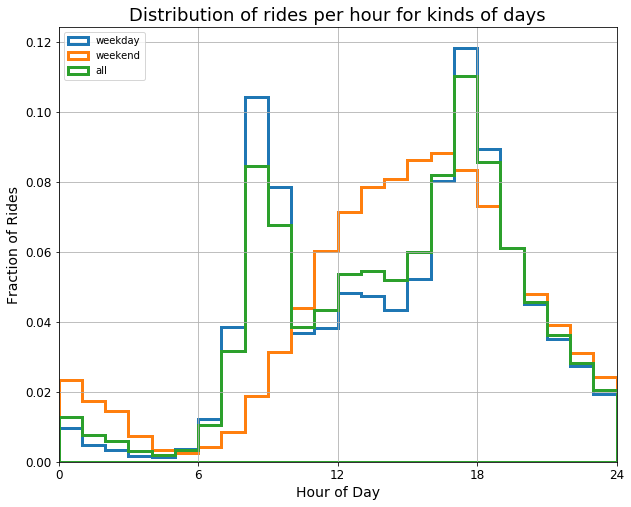

In [32]:
weekdays = bikes['trip_weekday'] < 5
weekends = bikes['trip_weekday'] >= 5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
bikes.loc[weekdays, 'trip_hour'].hist(ax=ax, bins=24, density=True, label='weekday',
                                      histtype= "stepfilled", facecolor='none', lw=3,
                                      edgecolor=get_cat10(0))
bikes.loc[weekends, 'trip_hour'].hist(ax=ax, bins=24, density=True, label='weekend',
                                       histtype= "stepfilled", facecolor='none', lw=3,
                                       edgecolor=get_cat10(1))
bikes['trip_hour'].hist(ax=ax, bins=24, density=True, label='all',
                        histtype= "stepfilled", facecolor='none', lw=3,
                        edgecolor=get_cat10(2))
ax.set_xlim([0, 24])
ax.set_xticks([0, 6, 12, 18, 24])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("Fraction of Rides", fontsize=14)
ax.set_title("Distribution of rides per hour for kinds of days", fontsize=18)
ax.legend(loc=2);

That's quite beautiful!  We see two peaks corresponding to rush hour traffic in the weekday histogram, with off-rush-hour travel biased slightly toward the afternoon, likely due to leisure travel.  The weekend distribution only has a single peak at around 4 PM, and its width is much larger than the rush hour peaks from the weekday distribution.  This probably reflects a greater diversity of times for leisure travel.

It is inappropriate to compare the relative heights of the distributions and conclude that, for example, there are more riders on at noon on the weekends than the weekdays, since we've normalized those distributions.  To make that comparison, we need to look at the average number of rides per day:

In [33]:
avgrides = (bikes.groupby([bikes['trip_hour'].astype(int)  + 0.5, weekdays, 'user_type'])['trip_id']
            .count()
            .reset_index(level=1)
            .rename(columns={'trip_weekday': 'Weekday', 'trip_id': 'Number of Rides'}))
avgrides.loc[avgrides['Weekday'], 'Number of Rides'] = avgrides.loc[avgrides['Weekday'], 'Number of Rides'] / 5.
avgrides.loc[~avgrides['Weekday'], 'Number of Rides'] = avgrides.loc[~avgrides['Weekday'], 'Number of Rides'] / 2.

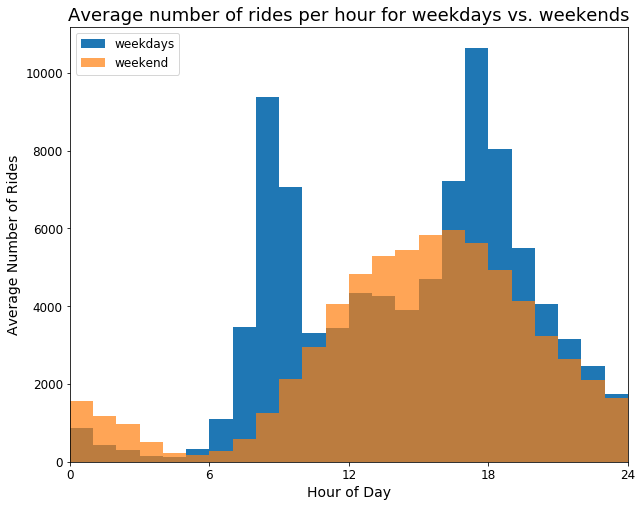

In [34]:
total_rides = avgrides.groupby(['trip_hour', 'Weekday']).sum().unstack()
total_rides.columns.set_levels([('Number of Rides',),
                                ('Weekend', 'Weekday')], inplace=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
ax.bar(total_rides.index, total_rides[('Number of Rides', 'Weekday')],
       width=1, lw=0, facecolor=get_cat10(0), label='weekdays')
ax.bar(total_rides.index, total_rides[('Number of Rides', 'Weekend')],
       width=1, lw=0, alpha=0.7, facecolor=get_cat10(1), label='weekend')
ax.set_xlim([0, 24])
ax.set_xticks([0, 6, 12, 18, 24])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("Average Number of Rides", fontsize=14)
ax.set_title("Average number of rides per hour for weekdays vs. weekends", fontsize=18)
ax.legend(loc=2, fontsize=12);

So there are definitely more riders around noon on weekends.  Let's further subdivide this into member and casual riders (the former have an account with Toronto Bikeshare, the latter just purchase the ride).

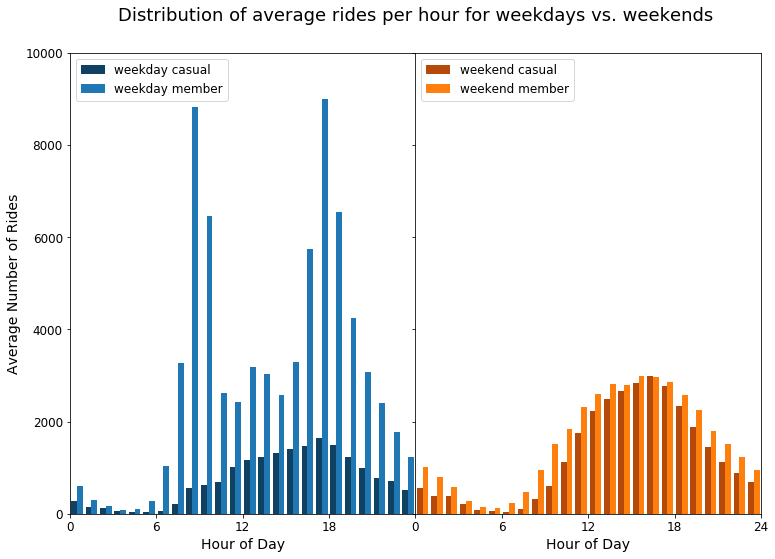

In [35]:
weekday_avg = avgrides.loc[avgrides['Weekday'], 'Number of Rides'].unstack()
weekend_avg = avgrides.loc[~avgrides['Weekday'], 'Number of Rides'].unstack()

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.8])
ax2 = fig.add_axes([0.5, 0.1, 0.4, 0.8])
# ax1.bar(weekday_avg.index, weekday_avg['Casual'], width=0.9,
#         facecolor='#104163', label='weekday casual')
# ax1.bar(weekday_avg.index, weekday_avg['Member'], width=0.9,
#         bottom=weekday_avg['Casual'], facecolor='#1f77b4', label='weekday member')
# ax2.bar(weekend_avg.index, weekend_avg['Casual'], width=0.9,
#         facecolor='#b5490a', label='weekend casual')
# ax2.bar(weekend_avg.index, weekend_avg['Member'], width=0.9,
#         bottom=weekend_avg['Casual'], facecolor='#ff7f0e', label='weekend member')
barwidth = 0.4
ax1.bar(weekday_avg.index - barwidth / 2., weekday_avg['Casual'], width=barwidth,
        facecolor='#104163', label='weekday casual')
ax1.bar(weekday_avg.index + barwidth / 2., weekday_avg['Member'], width=barwidth,
        facecolor='#1f77b4', label='weekday member')
ax2.bar(weekend_avg.index - barwidth / 2., weekend_avg['Casual'], width=barwidth,
        facecolor='#b5490a', label='weekend casual')
ax2.bar(weekend_avg.index + barwidth / 2., weekend_avg['Member'], width=barwidth,
        facecolor='#ff7f0e', label='weekend member')
ax1.set_ylim([0, 10000])
ax1.set_xlim([0, 24])
ax1.set_xticks([0, 6, 12, 18])
ax2.set_ylim([0, 10000])
ax2.set_xlim([0, 24])
ax2.set_xticks([0, 6, 12, 18, 24])
ax2.set_yticklabels([''])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel("Hour of Day", fontsize=14)
ax2.set_xlabel("Hour of Day", fontsize=14)
ax1.set_ylabel("Average Number of Rides", fontsize=14)
fig.suptitle("Distribution of average rides per hour for weekdays vs. weekends", fontsize=18)
ax1.legend(loc=2, fontsize=12)
ax2.legend(loc=2, fontsize=12);

We find that the weekday rush hour peaks of rides are solely due to member riders (which makes sense - they're probably the ones who need reliable service during workday commutes).  There are roughly equal numbers of casual and member riders on weekends, and there are more of either than casual riders during weekdays.  The peak ridership for these is all around 5 PM.

We already sort of looked at this, but what are the typical trip durations on weekdays and weekends?

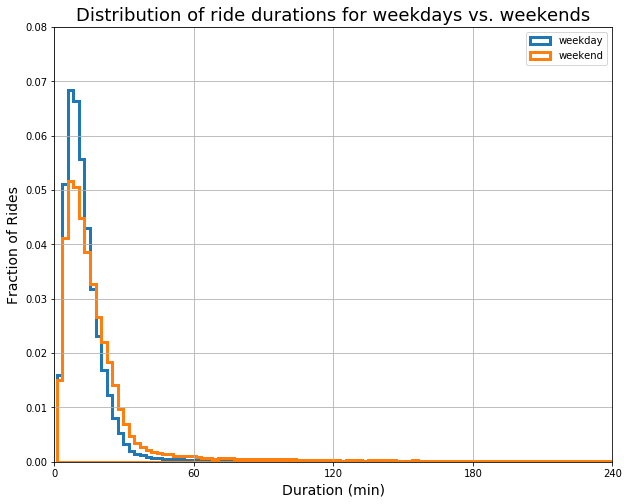

In [36]:
bikes['trip_duration_minutes'] = bikes['trip_duration_seconds'] / 60.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
bikes.loc[weekdays, 'trip_duration_minutes'].hist(
    ax=ax, bins=100, density=True, label='weekday', histtype= "stepfilled",
    facecolor='none', lw=3, edgecolor=get_cat10(0))
bikes.loc[weekends, 'trip_duration_minutes'].hist(
    ax=ax, bins=100, density=True, label='weekend', histtype= "stepfilled",
    facecolor='none', lw=3, edgecolor=get_cat10(1))
ax.set_ylim([0, 0.08])
ax.set_xlim([0, 240])
ax.set_xticks([0, 60, 120, 180, 240])
ax.set_xlabel("Duration (min)", fontsize=14)
ax.set_ylabel("Fraction of Rides", fontsize=14)
ax.set_title("Distribution of ride durations for weekdays vs. weekends", fontsize=18)
ax.legend(loc=1);

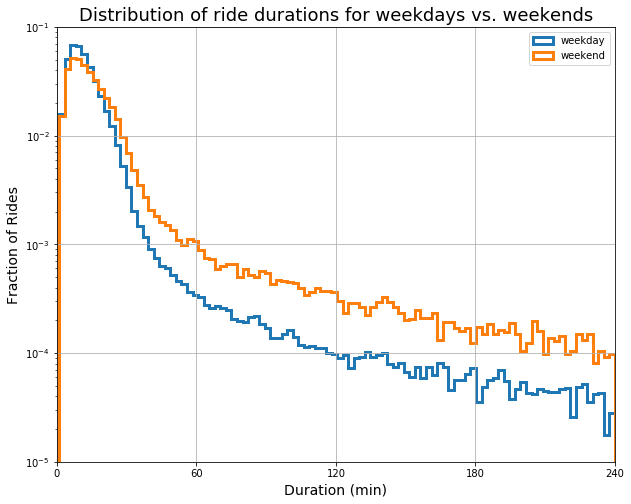

In [37]:
bikes['trip_duration_minutes'] = bikes['trip_duration_seconds'] / 60.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
bikes.loc[weekdays, 'trip_duration_minutes'].hist(
    ax=ax, bins=100, density=True, label='weekday', histtype= "stepfilled",
    facecolor='none', lw=3, edgecolor=get_cat10(0), log=True)
bikes.loc[weekends, 'trip_duration_minutes'].hist(
    ax=ax, bins=100, density=True, label='weekend', histtype= "stepfilled",
    facecolor='none', lw=3, edgecolor=get_cat10(1), log=True)
ax.set_ylim([1e-5, 1e-1])
ax.set_xlim([0, 240])
ax.set_xticks([0, 60, 120, 180, 240])
ax.set_xlabel("Duration (min)", fontsize=14)
ax.set_ylabel("Fraction of Rides", fontsize=14)
ax.set_title("Distribution of ride durations for weekdays vs. weekends", fontsize=18)
ax.legend(loc=1);

In [38]:
print("Median trip time for weekdays: {0:.3f}".format(
    bikes.loc[weekdays, 'trip_duration_minutes'].median()))
print("Median trip time for weekdays: {0:.3f}".format(
    bikes.loc[weekends, 'trip_duration_minutes'].median()))

Median trip time for weekdays: 10.850
Median trip time for weekdays: 13.283


Typical trips are less than 15 minutes long, as indicated by the median.  Weekend trips tend to be longer, but only slightly, and while there's roughly a factor of 2 more rides that are $\gtrsim$ 1 hour long on the weekends than the weekdays, these represent of order a percent of all rides.

Finally, let's have a look at the most popular stations.

In [39]:
from matplotlib import colors as mpl_colors
from matplotlib import cm as mpl_cm
plasma_cmap = mpl_cm.get_cmap('plasma')
viridis_cmap = mpl_cm.get_cmap('viridis')
bwr_cmap = mpl_cm.get_cmap('bwr')

# Secrets module with mapbox public token
import secrets

import plotly
plotly.tools.set_credentials_file(username=secrets.PLOTLY_USER,
                                  api_key=secrets.PLOTLY_API)
import plotly.plotly as py_online
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

def get_station_locations(stations, n=10):
    stations = stations.value_counts()[:n].reset_index()
    stations.columns = ['station_id', 'N_rides']
    return stations.merge(all_bike_stations[['station_id', 'lat',
                                             'lon', 'capacity', 'Name']],
                          how='left', on='station_id')

popular_from_stns_members = get_station_locations(bikes.loc[bikes['user_type'] == 'Member',
                                                            'from_station_id'])
popular_from_stns_guests = get_station_locations(bikes.loc[bikes['user_type'] == 'Casual',
                                                           'from_station_id'])
popular_to_stns_members = get_station_locations(bikes.loc[bikes['user_type'] == 'Member',
                                                          'to_station_id'])
popular_to_stns_guests = get_station_locations(bikes.loc[bikes['user_type'] == 'Casual',
                                                         'to_station_id'])

In [40]:
global_max_traffic = max([popular_from_stns_members['N_rides'].max(),
                          popular_from_stns_guests['N_rides'].max(),
                          popular_to_stns_members['N_rides'].max(),
                          popular_to_stns_guests['N_rides'].max()])

global_min_traffic = min([popular_from_stns_members['N_rides'].min(),
                          popular_from_stns_guests['N_rides'].min(),
                          popular_to_stns_members['N_rides'].min(),
                          popular_to_stns_guests['N_rides'].min()])

In [41]:
# https://plot.ly/python/reference/#scattermapbox
data = [
    go.Scattermapbox(
        lat=popular_from_stns_members['lat'].values,
        lon=popular_from_stns_members['lon'].values,
        mode='markers',
        marker=dict(
            symbol='circle',
            opacity=1.0,
            size=popular_from_stns_members['capacity'].values / 1.5,
            color= [mpl_colors.rgb2hex(plasma_cmap(
                        (N_ride - global_min_traffic) / global_max_traffic)[:3])
                    for N_ride in popular_from_stns_members['N_rides'].values],
        ),
        text=(popular_from_stns_members['Name'].values + '<br>Number of departures: ' +
              popular_from_stns_members['N_rides'].astype(str)),
        name='Origin',
    ),
    go.Scattermapbox(
        lat=popular_to_stns_members['lat'].values,
        lon=popular_to_stns_members['lon'].values,
        mode='markers',
        marker=dict(
            symbol='circle',
            opacity=1.0,
            size=popular_to_stns_members['capacity'].values / 1.5,
            color= [mpl_colors.rgb2hex(viridis_cmap(
                        (N_ride - global_min_traffic) / global_max_traffic)[:3])
                    for N_ride in popular_to_stns_members['N_rides'].values],
        ),
        text=(popular_to_stns_members['Name'].values + '<br>Number of arrivals: ' +
              popular_to_stns_members['N_rides'].astype(str)),
        name='Destination',
    )
]

layout = go.Layout(
    title='Stations most popular with members',
    autosize=False,
    width=800,
    height=600,
    hovermode='closest',
    mapbox=dict(
        accesstoken=secrets.MAPBOX_TOKEN,
        bearing=0,
        center=dict(
            lat=43.6532,
            lon=-79.3832
        ),
        pitch=0,
        zoom=12,
        style='mapbox://styles/cczhu/cjounit2f1cwm2sl62e2jzjqs'
    ),
    margin=dict(l=0, r=0, t=50, b=0),
)

fig = dict(data=data, layout=layout)

iplot(fig)

Here we plot the top 10 origin and destination bike stations (each can be toggled on and off using the panel on the right).  The size of each station is given by its 2018 capacity (a rough proxy for 2016, but it's all we have) and the colour the number of rides departing/arriving.  The location and exact number of rides is displayed when hovering the mouse over a station.

We see that the top 10 stations are all in downtown, and the most popular origin stations almost completely overlap with the most popular destination ones.

In [42]:
# https://plot.ly/python/reference/#scatter
data = [
    go.Scattermapbox(
        lat=popular_from_stns_guests['lat'].values,
        lon=popular_from_stns_guests['lon'].values,
        mode='markers',
        marker=dict(
            symbol='circle',
            opacity=1.0,
            size=popular_from_stns_guests['capacity'].values / 1.5,
            color= [mpl_colors.rgb2hex(plasma_cmap(
                        (N_ride - global_min_traffic) / global_max_traffic)[:3])
                    for N_ride in popular_from_stns_guests['N_rides'].values],
        ),
        text=(popular_from_stns_guests['Name'].values + '<br>Number of departures: ' +
              popular_from_stns_guests['N_rides'].astype(str)),
        name='Origin',
    ),
    go.Scattermapbox(
        lat=popular_to_stns_guests['lat'].values,
        lon=popular_to_stns_guests['lon'].values,
        mode='markers',
        marker=dict(
            symbol='circle',
            opacity=1.0,
            size=popular_to_stns_guests['capacity'].values / 1.5,
            color= [mpl_colors.rgb2hex(viridis_cmap(
                        (N_ride - global_min_traffic) / global_max_traffic)[:3])
                    for N_ride in popular_to_stns_guests['N_rides'].values],
        ),
        text=(popular_to_stns_guests['Name'].values + '<br>Number of arrivals: ' +
              popular_to_stns_guests['N_rides'].astype(str)),
        name='Destination',
    )
]

layout = go.Layout(
    title='Stations most popular with guests',
    autosize=False,
    width=800,
    height=600,
    hovermode='closest',
    mapbox=dict(
        accesstoken=secrets.MAPBOX_TOKEN,
        bearing=0,
        center=dict(
            lat=43.6532,
            lon=-79.3832
        ),
        pitch=0,
        zoom=12,
        style='mapbox://styles/cczhu/cjounit2f1cwm2sl62e2jzjqs'
    ),
    margin=dict(l=0, r=0, t=50, b=0),
)

fig = dict(data=data, layout=layout)

iplot(fig)

We find the same trends for guests, except that there are overall far fewer guests taking rides than members, and guests tend to borrow and return bikes at stations along the lakeshore.

# Prototype Dashboard Visualization

Finally, as preparation for the dash app, I plot all rides **in progress at a user-specified time**.  Here, journeys are plotted as green lines, and the number of bikes taking the journey determines the thickness of the line.  Stations are plotted as circles, the total number of bicycles arriving at and departing from each station is loosely indicated by its size, and the net number of arrivals and departures is indicated by the stations' colours (blue for mostly departing, white for net zero, red for mostly arriving).

In [43]:
def get_rider_lines(ride_trajectories, n_riders):
    rider_subset = ride_trajectories.index[ride_trajectories['N_rides'] == n_riders]
    return go.Scattermapbox(
        lat=(np.vstack([ride_trajectories.loc[rider_subset, 'lat_from'].values,\
                        ride_trajectories.loc[rider_subset, 'lat_to'].values]).T.ravel()),
        lon=(np.vstack([ride_trajectories.loc[rider_subset, 'lon_from'].values,
                        ride_trajectories.loc[rider_subset, 'lon_to'].values]).T.ravel()),
        mode='lines',
        line=dict(
            color='#35bf49',
            width=np.minimum(0.25 * n_riders**2, 20),
        ),
        hoverinfo='none',
        name='Trips' + str(n_riders))


def make_ride_map(want_time, public=False):
    current_rides = bikes[(bikes['trip_start_time'] <= want_time) &
                          (bikes['trip_stop_time'] > want_time)]

    # Determine balance of arriving and department rides for stations.
    station_balance = pd.DataFrame(dict(
        from_station=current_rides.groupby('from_station_id')['trip_id'].count(),
        to_station=current_rides.groupby('to_station_id')['trip_id'].count()))
    station_balance.reset_index(inplace=True)
    station_balance.columns = ['station_id', 'N_departing', 'N_arriving']

    stations = (all_bike_stations.copy()
                .merge(station_balance, how='left',
                       left_on='station_id', right_on='station_id')
                .fillna(value=0.))

    stations['N_total'] = stations['N_departing'] + stations['N_arriving']
    stations['N_balance'] = ((stations['N_arriving'] - stations['N_departing']) /
                             (2. * stations['N_total'])) + 0.5
    stations['N_balance'].fillna(0.5, inplace=True)

    # Determine all unique origin/destination pairs for rides, and count the number of rides
    # for each journey.
    ride_trajectories = current_rides.groupby(
        ['from_station_id', 'to_station_id'])['trip_id'].count().reset_index()
    ride_trajectories = (
        ride_trajectories.merge(all_bike_stations[['lat', 'lon', 'station_id']], how='left',
                                left_on='from_station_id', right_on='station_id')
                         .rename(columns={'trip_id': 'N_rides', 'lat': 'lat_from', 'lon': 'lon_from'})
                         .merge(all_bike_stations[['lat', 'lon', 'station_id']], how='left',
                                left_on='to_station_id', right_on='station_id')
                         .rename(columns={'lat': 'lat_to', 'lon': 'lon_to'}))

    # https://plot.ly/python/reference/#scatter
    # I can't find a way to vary the thickness of this line except with different Plotly traces,
    # so plot trajectories with different numbers of riders separately.
    n_riders_arr = ride_trajectories['N_rides'].unique()
    data = [get_rider_lines(ride_trajectories, n_riders)
            for n_riders in n_riders_arr]
    
    # Add stations.
    data += [
        go.Scattermapbox(
            lat=stations['lat'].values,
            lon=stations['lon'].values,
            mode='markers',
            marker=dict(
                symbol='circle',
                opacity=1.0,
                size=np.maximum(5., 4 * (stations['N_total'].values)**(2./3.)),
                color= [mpl_colors.rgb2hex(bwr_cmap(balance)[:3])
                        for balance in stations['N_balance'].values],
            ),
            text=stations['Name'].values,
            name='Stations',
        ),
    ]

    layout = go.Layout(
        title='Active rides at ' + want_time,
        autosize=False,
        width=800,
        height=600,
        hovermode='closest',
        mapbox=dict(
            accesstoken=secrets.MAPBOX_TOKEN,
            bearing=0,
            center=dict(
                lat=43.6532,
                lon=-79.3932
            ),
            pitch=0,
            zoom=12,
            style='mapbox://styles/cczhu/cjounit2f1cwm2sl62e2jzjqs'
        ),
        margin=dict(l=0, r=0, t=50, b=0),
        showlegend=False,
    )

    fig = dict(data=data, layout=layout)

    if public:
        py_online.iplot(fig)
    else:
        iplot(fig)

### Typical Weekday (Wednesday, September 21st, 2016)

In [44]:
make_ride_map('2016-09-21 08:30:00')

In [45]:
make_ride_map('2016-09-21 17:30:00')

### Comparing a typical weekend day 3 AM with Nuit Blanche (Sunday, October 2nd, 2016)

In [46]:
make_ride_map('2016-10-01 03:00:00')

In [47]:
# Nuit Blanche 2016
# https://www.blogto.com/arts/2016/09/the_top_20_exhibits_to_check_out_at_nuit_blanche_2016/
make_ride_map('2016-10-02 03:00:00')

In [48]:
# Pass plot to plotly public server
make_ride_map('2016-09-21 08:30:00', public=True)